# 4 - 打包填充序列，掩码，推断和 BLEU

## 简介

在这个笔记本中，我们将为上一个笔记本中的模型添加一些改进 - 打包填充序列和掩码。打包填充序列用于告诉我们的 RNN 在编码器中跳过 `<pad>` token。掩码明确地强制模型忽略某些值，例如对填充元素的注意力。这两种技术在自然语言处理中常被使用。

我们还将看看如何将我们的模型用于推断，通过给它一个句子，查看它的翻译结果以及在翻译每个单词时它关注的具体位置。

最后，我们将使用 BLEU 指标来衡量我们翻译的质量。

## 数据准备

首先，我们将导入所有的模块，与之前一样，还增加了用于查看注意力的 `matplotlib` 模块。


In [33]:
import mindspore as ms
import mindspore.context as context
import mindspore.nn as nn
import mindspore.ops as ops

import random
import numpy as np
import spacy
import datasets
from tqdm.notebook import tqdm
import evaluate
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
ms.set_seed(seed)

导入数据集，接下来不再赘述

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")
def tokenize_example(
    example,
    en_nlp,
    de_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}


max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "de_nlp": de_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}


train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Found cached dataset json (/root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-39e2a81dd5826464.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-340eed13fdfe768e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-05a87c7dda3754fe.arrow


In [4]:
import collections
class Vocab:
    """一个词汇表的实现"""
    def __init__(self, tokens:list, min_freq=0, reserved_tokens:list=None) -> None:
        self.default_index = None
        if tokens is not None:
            # 当第一个条件满足时，就不会跳到第二个判断，避免了空列表报错的情况。
            if len(tokens)!=0 and isinstance(tokens[0], list):
                tokens = [i for line in tokens for i in line]
        else:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter=collections.Counter(tokens)
        # 按出现词频从高到低排序
        self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        # 通过列表,利用序号访问词元。
        self.idx_to_token = [] + reserved_tokens # 未知词元<unk>的索引为0, 保留词元排在最前
        self.token_to_idx = {
            i: k
            for k, i in enumerate(self.idx_to_token) 
        }
        
        for token, freq in self._token_freqs:
            if freq < min_freq:  # 过滤掉出现频率低于要求的词
                break
            if token not in self.token_to_idx:  
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, input_tokens):
        """输入单字串或序列, 将其全部转化为序号编码"""
        if isinstance(input_tokens, str):
            out =  self.token_to_idx.get(input_tokens, self.default_index)
            if out is None:
                raise Exception('Please call "set_default_index" before getting unknown index')
            return out
        return [self.__getitem__(token) for token in input_tokens]
    
    def __repr__(self) -> str:
        show_items = 5 if len(self) > 5 else len(self)
        out = f"<Vocab with {len(self)} tokens: "
        for i in range(show_items):
            out += f'"{self.idx_to_token[i]}", '
        out += "...>"
        return out

    def __contains__(self, token:str) -> bool:
        return token in self.idx_to_token

    def to_tokens(self, input_keys):
        """输入单s索引或序列, 将其全部转化为词元"""
        if isinstance(input_keys, int):
            return self.idx_to_token[input_keys] if input_keys < len(self) else self.idx_to_token[0]
        elif isinstance(input_keys, (list, tuple)):
            return [self.to_tokens(keys) for keys in input_keys]
        else:
            return self.idx_to_token[0]
    
    def get_itos(self):
        return self.idx_to_token
    
    def get_stoi(self):
        return self.token_to_idx
    
    def set_default_index(self, idx):
        if isinstance(idx, int):
            self.default_index = idx
        else:
            raise Exception(f"Only type int allowed, got {type(idx)}")

    def lookup_indices(self, input_tokens):
        return self.__getitem__(input_tokens)
    
    def lookup_tokens(self, idx):
        return self.to_tokens(idx)

In [5]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

def build_vocab_from_iterator(tokens, min_freq, specials):
    return Vocab(tokens, min_freq, specials)

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

fn_kwargs = {
"en_vocab": en_vocab, 
"de_vocab": de_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-6689c04abfdb721f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-acab783df695b18d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e1088b8589007c26.arrow


In [6]:
data_type = "numpy"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [7]:
def pad_sequence(sequences:list, padding_value:int):
    '''将序列填充到等长并返回mindspore张量'''
    # Find the length of the longest sequence in the batch
    max_length = max(len(seq) for seq in sequences)
    padded_sequences:ms.Tensor = ops.full((len(sequences), max_length), padding_value, dtype=ms.int64)
    # Copy the sequences into the padded array
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = ms.tensor(seq).astype(np.int64)
    # 换轴，保证输出为时序优先
    padded_sequences = padded_sequences.swapaxes(0, 1)
    return padded_sequences  

def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch
    
    return collate_fn

In [8]:
class DataLoader:
    def __init__(self, source, batch_size, shuffle=False, per_batch_map=None):
        self.source = source
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.per_batch_map = per_batch_map
        self.indices = np.arange(len(source))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.source):
            self.current_index = 0
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.source[int(i)] for i in batch_indices]

        if self.per_batch_map:
            batch_data = self.per_batch_map(batch_data)

        self.current_index += self.batch_size
        return batch_data
    
    def __len__(self):
        return len(self.source) // self.batch_size


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle, per_batch_map=collate_fn)
    
    return dataloader

In [9]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## 构建模型

### 编码器

接下来，我们定义编码器。

主要的变化发生在 `construct` 方法中。现在，它不仅接受源句子，还接受源句子的长度。

在对源句子进行嵌入后（由迭代器自动填充），我们可以使用 `pack_padded_sequence` 和句子的长度`src_len`。`packed_embedded` 将成为我们的打包填充序列。然后，我们可以像往常一样将其馈送到我们的RNN中，该RNN将返回 `packed_outputs`，其中包含序列中的所有隐藏状态，以及 `hidden`，它只是我们序列的最终隐藏状态。`hidden` 是一个标准张量，没有以任何方式打包，唯一的区别是由于输入是一个打包的序列，此张量来自序列中的最终 **非填充元素**。(用于加快计算速度，目前Mindspore中无此功能)

然后，我们使用 `pad_packed_sequence` 解压我们的 `packed_outputs`，它返回 `outputs` 和每个序列的长度，但我们不需要这些长度。

`outputs` 的第一个维度是填充序列长度，但由于使用了打包填充序列，当填充token是输入时，张量的值将全部为零。


In [10]:
class Encoder(nn.Cell):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Dense(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        outputs, hidden = self.rnn(embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        # outputs, _ = nn.utils.rnn.pad_pacedk_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = ops.tanh(self.fc(ops.cat((hidden[-2,:,:], hidden[-1,:,:]), axis = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### 注意力

注意力模块是我们计算源语句上的注意力值的地方。

以前，我们允许此模块“关注”源语句中的填充标记。但是，使用*masking*，我们可以强制注意力仅集中在非填充元素上。

`construct` 方法现在接受一个 `mask` 输入。这是一个 **[batch size, source sentence length]** 的张量，当源语句标记不是填充标记时为1，当它是填充标记时为0。例如，如果源语句是: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]，那么 mask 将是 [1, 1, 1, 1, 1, 0, 0]。

我们在计算注意力后但在通过 `softmax` 函数进行规范化之前应用掩码。它使用 `masked_fill` 进行应用。这会在第一个参数（`mask == 0`）为真的每个元素处，用第二个参数给定的值（`-1e10`）填充张量。换句话说，它将取未规范化的注意值，并将填充元素上的注意值更改为 `-1e10`。由于与其他值相比，这些数字将是微不足道的，因此当通过 `softmax` 层传递时，它们将变为零，确保在源语句中不关注填充标记。


In [11]:
class Attention(nn.Cell):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Dense((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Dense(dec_hid_dim, 1, has_bias = False)
        
    def construct(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).tile((1, src_len, 1))
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = ops.tanh(self.attn(ops.cat((hidden, encoder_outputs), axis = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return ops.softmax(attention, axis = 1)

### 解码器

解码器只需要进行一些小的更改。它需要接受源语句上的掩码并将其传递到注意力模块。由于我们希望在推断期间查看注意力的值，因此我们还返回注意张量。


In [12]:
class Decoder(nn.Cell):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Dense((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        input = input.unsqueeze(0)
        #input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs, mask)      
        #a = [batch size, src len]
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        weighted = ops.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        rnn_input = ops.cat((embedded, weighted), axis = 2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(ops.cat((output, weighted, embedded), axis = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

为了使用打包填充的序列、掩码和推断，总体 seq2seq 模型还需要一些更改。

我们需要告诉它 pad token的索引，并将源语句长度作为输入传递给 `construct` 方法。

我们使用 pad token索引创建掩码，方法是创建一个遮罩张量，在源语句不等于 pad token的地方为 1。这一切都在 `create_mask` 函数中完成。

序列长度需要传递给编码器以使用打包填充的序列。

每个时间步的注意力存储在 `attentions` 中


In [13]:
class Seq2Seq(nn.Cell):
    def __init__(self, encoder:Encoder, decoder:Encoder, src_pad_idx):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).astype(ms.int32).permute(1, 0)
        return mask
        
    def construct(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #存储解码器输出
        outputs = []

        # 编码器（encoder）：
        # 输入：源序列、源序列长度
        # 输出1：编码器中所有前向与反向RNN 的隐藏状态 encoder_outputs
        # 输出2：编码器中前向与反向RNN中最后时刻的隐藏状态放入线性层后的输出 hidden
        encoder_outputs, hidden = self.encoder(src, src_len)

        #解码器的第一个输入是表示序列开始的占位符<bos>
        inputs = trg[0,:]

        # 标记源序列中<pad>占位符的位置
        # shape = [batch size, src len]
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):
            # 解码器（decoder）：
            # 输入：源句子序列 inputs、前一时刻的隐藏状态 hidden、编码器所有前向与反向RNN的隐藏状态
            # 标明每个句子中的<pad>，方便计算注意力权重时忽略该部分
            # 输出：预测结果 output、新的隐藏状态 hidden、注意力权重（忽略）
            output, hidden, _ = self.decoder(inputs, hidden, encoder_outputs, mask)
            if len(outputs) == 0:
                outputs.append(ops.zeros(output.shape, dtype=output.dtype))

            # 将预测结果放入之前的存储中
            outputs.append(output)

            #找出对应预测概率最大的词元
            top1 = output.argmax(1).astype(ms.int32)

            if self.training:
                #如果目前为模型训练状态，则按照之前设定的概率使用teacher forcing
                teacher_force = random.random() < teacher_forcing_ratio
                # 如使用teacher forcing，则将目标序列中对应的词元作为下一个输入
                # 如不使用teacher forcing，则将预测结果作为下一个输入
                inputs = trg[t] if teacher_force else top1
            else:
                inputs = top1

        # 将所有输出整合为tensor
        outputs = ops.stack(outputs, axis=0)

        return outputs


In [16]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
SRC_PAD_IDX = de_vocab.get_stoi()[pad_token]


attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)


model = Seq2Seq(encoder, decoder, SRC_PAD_IDX)

In [17]:
def init_weights(m:nn.Cell):
    for name, param in m.parameters_and_names():
        if "weight" in name:
            param.set_data(ops.normal(param.shape, ms.Tensor([0.]), ms.Tensor([0.01])))
        else:
            param.set_data(ops.zeros(param.shape, dtype=param.dtype))

model.apply(init_weights)

Seq2Seq<
  (encoder): Encoder<
    (embedding): Embedding<vocab_size=7853, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=encoder.embedding.embedding_table, shape=(7853, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (rnn): GRU<
      (rnn): _DynamicGRUCPUGPU<>
      (dropout_op): Dropout<p=0.0>
      >
    (fc): Dense<input_channels=1024, output_channels=512, has_bias=True>
    (dropout): Dropout<p=0.5>
    >
  (decoder): Decoder<
    (attention): Attention<
      (attn): Dense<input_channels=1536, output_channels=512, has_bias=True>
      (v): Dense<input_channels=512, output_channels=1>
      >
    (embedding): Embedding<vocab_size=5893, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=decoder.embedding.embedding_table, shape=(5893, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (rnn): GRU<
      (rnn): _DynamicGRUCPUGPU<>
      (dropout_op): Dropout<p=0.0>
      >
    (fc_o

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.get_parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [19]:
optimizer = nn.Adam(model.trainable_params())

In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [21]:
def forward_fn(src, src_len, trg, teacher_forcing_ratio):
    # src = [src length, batch size]
    # trg = [trg length, batch size]
    output = model(src, src_len, trg, teacher_forcing_ratio)
    # output = [trg length, batch size, trg vocab size]
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    # output = [(trg length - 1) * batch size, trg vocab size]
    trg = trg[1:].view(-1)
    # trg = [(trg length - 1) * batch size]
    loss = criterion(output, trg.astype(ms.int32))
    return loss

grad_fn = ms.value_and_grad(forward_fn, grad_position=None, weights=model.trainable_params())


def train_fn(data_loader, optimizer, clip, teacher_forcing_ratio):
    epoch_loss = 0.
    model.set_train(True)
    for i, batch in enumerate(tqdm(data_loader)):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        src_len = src.shape[0]
        loss, grads = grad_fn(src, src_len, trg, teacher_forcing_ratio)
        # grads = ops.clip_by_norm(grads, max_norm=clip)
        optimizer(grads)
        epoch_loss += float(loss)

    return epoch_loss / len(data_loader)

In [22]:
def evaluate_fn(model:Seq2Seq, data_loader, criterion):
    """模型验证"""
    model.set_train(False)
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        src_len = src.shape[0]

        output = model(src, src_len, trg, 0) # turn off teacher forcing
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg.astype(ms.int32))
        epoch_loss += float(loss)

    return epoch_loss / len(data_loader)

In [23]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        train_data_loader, 
        optimizer, 
        clip, 
        teacher_forcing_ratio, 
    )
    
    valid_loss = evaluate_fn(
        model, 
        valid_data_loader, 
        criterion, 
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        ms.save_checkpoint(model, f"./tut4-model.ckpt")
    
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   5.141 | Train PPL: 170.885
	Valid Loss:   5.604 | Valid PPL: 271.597


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   4.282 | Train PPL:  72.351
	Valid Loss:   5.119 | Valid PPL: 167.157


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   3.757 | Train PPL:  42.802
	Valid Loss:   4.548 | Valid PPL:  94.439


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   3.160 | Train PPL:  23.569
	Valid Loss:   4.144 | Valid PPL:  63.023


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.746 | Train PPL:  15.583
	Valid Loss:   3.980 | Valid PPL:  53.498


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.430 | Train PPL:  11.354
	Valid Loss:   3.832 | Valid PPL:  46.163


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.197 | Train PPL:   8.994
	Valid Loss:   3.787 | Valid PPL:  44.122


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   1.971 | Train PPL:   7.179
	Valid Loss:   3.899 | Valid PPL:  49.375


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   1.798 | Train PPL:   6.040
	Valid Loss:   3.882 | Valid PPL:  48.506


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   1.676 | Train PPL:   5.345
	Valid Loss:   3.856 | Valid PPL:  47.257


最后，我们从最佳验证损失中加载参数，并在测试集上获得结果。

我们获得了改进的测试困惑度，同时速度几乎快了一倍！


In [24]:
ms.load_checkpoint(f"tut4-model.ckpt", model)

test_loss = evaluate_fn(model, test_data_loader, criterion)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")


| Test Loss: 3.761 | Test PPL:  42.995 |


## 推理

现在我们可以使用训练好的模型生成翻译。

**注意：**这些翻译与论文中显示的示例相比可能较差，因为它们使用了1000的隐藏维度大小并训练了4天！它们已经被精选，以展示在足够大的模型上应该是什么样的关注。

我们的 `translate_sentence` 将执行以下操作：
- 确保我们的模型处于评估模式，这在推理中应始终如此
- 如果尚未标记化（是字符串），则标记源句
- 数字化源句
- 将其转换为张量并添加批处理维度
- 获取源句长度并转换为张量
- 将源句馈送到编码器
- 为源句创建掩码
- 创建一个列表以保存输出句子，初始化为 `<sos>` token
- 创建一个张量以保存注意力值
- 当我们没有达到最大长度时
  - 获取输入张量，应该是 `<sos>` 或上次预测的token
  - 将输入、所有编码器输出、隐藏状态和掩码馈送到解码器
  - 存储注意值
  - 获取预测的下一个token
  - 将预测添加到当前输出句预测
  - 如果预测是 `<eos>` token，则中断
- 将输出句从索引转换为标记
- 返回输出句（去除 `<sos>` token）和整个序列上的注意力值


In [28]:
def translate_sentence(
    sentence, 
    model:Seq2Seq,
    en_nlp:spacy.Language,
    de_nlp:spacy.Language,
    en_vocab:Vocab,
    de_vocab:Vocab,
    lower,
    sos_token,
    eos_token,
    max_output_length=25,
):
    model.set_train(False)
    if isinstance(sentence, str):
        tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    ids = de_vocab.lookup_indices(tokens)

    tensor = ms.Tensor(ids).astype(ms.int64).unsqueeze(-1)
    encoder_outputs, hidden = model.encoder(tensor, len(ids))
    mask = model.create_mask(tensor)


    inputs = en_vocab.lookup_indices([sos_token])
    attentions = ops.zeros((max_output_length, 1, len(ids)))
    for i in range(max_output_length):
        inputs_tensor = ms.Tensor(inputs[-1]).unsqueeze(-1).astype(ms.int64)
        
        output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        predicted_token = output.argmax(-1).item()
        inputs.append(int(predicted_token))
        if predicted_token == en_vocab[eos_token]:
            break
    en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, tokens, attentions[:len(en_tokens)-1]

模型可能仅仅是记住了训练集的翻译。因此，我们也应该查看来自验证集和测试集的翻译。

首先，让我们从验证集中获取一个例子。我们将从数据集中获取一个源语言句子和对应的目标语言翻译。


In [26]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

然后，我们将使用 `translate_sentence` 函数来获取我们的预测翻译和注意力分布。
它在翻译上下文基本正确。

In [29]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 'is',
 'something',
 'something',
 '.',
 '<eos>']

接下来，我们将创建一个函数，用于显示模型在生成每个目标token时对源句的注意力。


In [55]:
def plot_attention(sentence, translation, attention:Attention):  
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    if isinstance(sentence, str):
        tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]

    x_ticks = [''] + ['<sos>'] + tokens + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

我们通过在 x 轴上放置源语言句子，y 轴上放置预测翻译来以图形方式展示这一过程。在两个单词之间的交叉点上，颜色越浅，模型在翻译该目标单词时对源单词的关注越多。


/usr/local/python-3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/python-3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


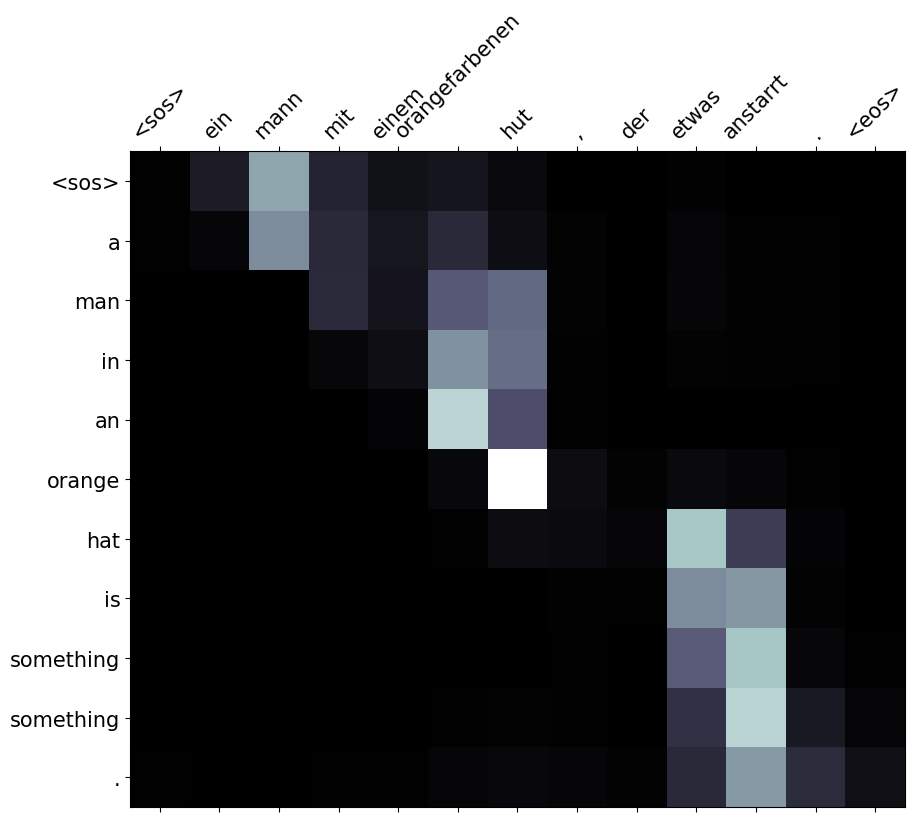

In [56]:
plot_attention(sentence, translation, attention)

## BLEU

以前我们只关心模型的损失/困惑度。然而，有一些专门用于测量翻译质量的指标 - 最流行的是 *BLEU*。不详细介绍，BLEU 从 n-gram 的角度考察了预测目标序列与实际目标序列的重叠程度。它会给我们每个序列一个介于 0 和 1 之间的数字，其中 1 表示完全重叠，即完美翻译，尽管通常显示在 0 和 100 之间。BLEU 最初是为每个源序列有多个候选翻译设计的，但在这个数据集中，每个源序列只有一个候选翻译。

我们从`evaluate`库中加载BLEU指标： 它用来计算数据集上的 BLEU 分数。该函数为每个源语句创建了实际翻译和预测翻译的语料库，然后计算 BLEU 分数。


In [57]:
bleu = evaluate.load("bleu")

循环遍历我们的 `test_data`，得到模型对每个测试句子的翻译。

In [59]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token, 
    )[0] for example in tqdm(test_data)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
predictions = [
    " ".join(translation[1:-1]) for translation in translations
]

references = [
    [example["en"]] for example in test_data
]

def get_tokenizer_fn(nlp, lower):
    
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
        
    return tokenizer_fn



In [61]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)
results = bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)
results

{'bleu': 0.29882945217820545,
 'precisions': [0.642085337960407,
  0.3826526243685247,
  0.23841183631426163,
  0.15342494059303646],
 'brevity_penalty': 0.970550398459947,
 'length_ratio': 0.970975647112881,
 'translation_length': 12679,
 'reference_length': 13058}

我们得到了约 0.299 的 BLEU 分数。如果我们将其与注意力模型试图复制的论文进行比较，与我们的分数相似，但是他们使用的是一个完全不同的数据集，并且他们的模型尺寸要大得多 - 1000 个隐藏维度，需要 4 天时间进行训练！- 因此我们不能真正与其进行比较。

这个数字并不真正可解释，我们不能真正从中得出什么结论。BLEU 分数最有用的部分是它可以用来比较同一数据集上的不同模型，其中 BLEU 分数**较高**的模型更“好”。

在接下来的教程中，我们将摆脱使用循环神经网络，并开始探讨构建序列到序列模型的其他方法。具体来说，在下一个教程中，我们将使用卷积神经网络。
